In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, LSTM, SpatialDropout1D,Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2024-07-08 18:53:46.391485: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 18:53:46.435824: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 18:53:46.619009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 18:53:47.457571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
for dirname, _, filenames in os.walk(r"../tests/UNSW_dataset/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")
test

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [4]:
df = pd.concat([train,test])

In [5]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [6]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [8]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [9]:
train = train.drop(['id'], axis=1)


In [10]:
df = df.drop(['id'],axis=1)

In [11]:
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,13,24,0,0,0,24,24,0,Generic,1
175337,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,3,13,0,0,0,3,12,0,Generic,1
175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,14,30,0,0,0,30,30,0,Generic,1


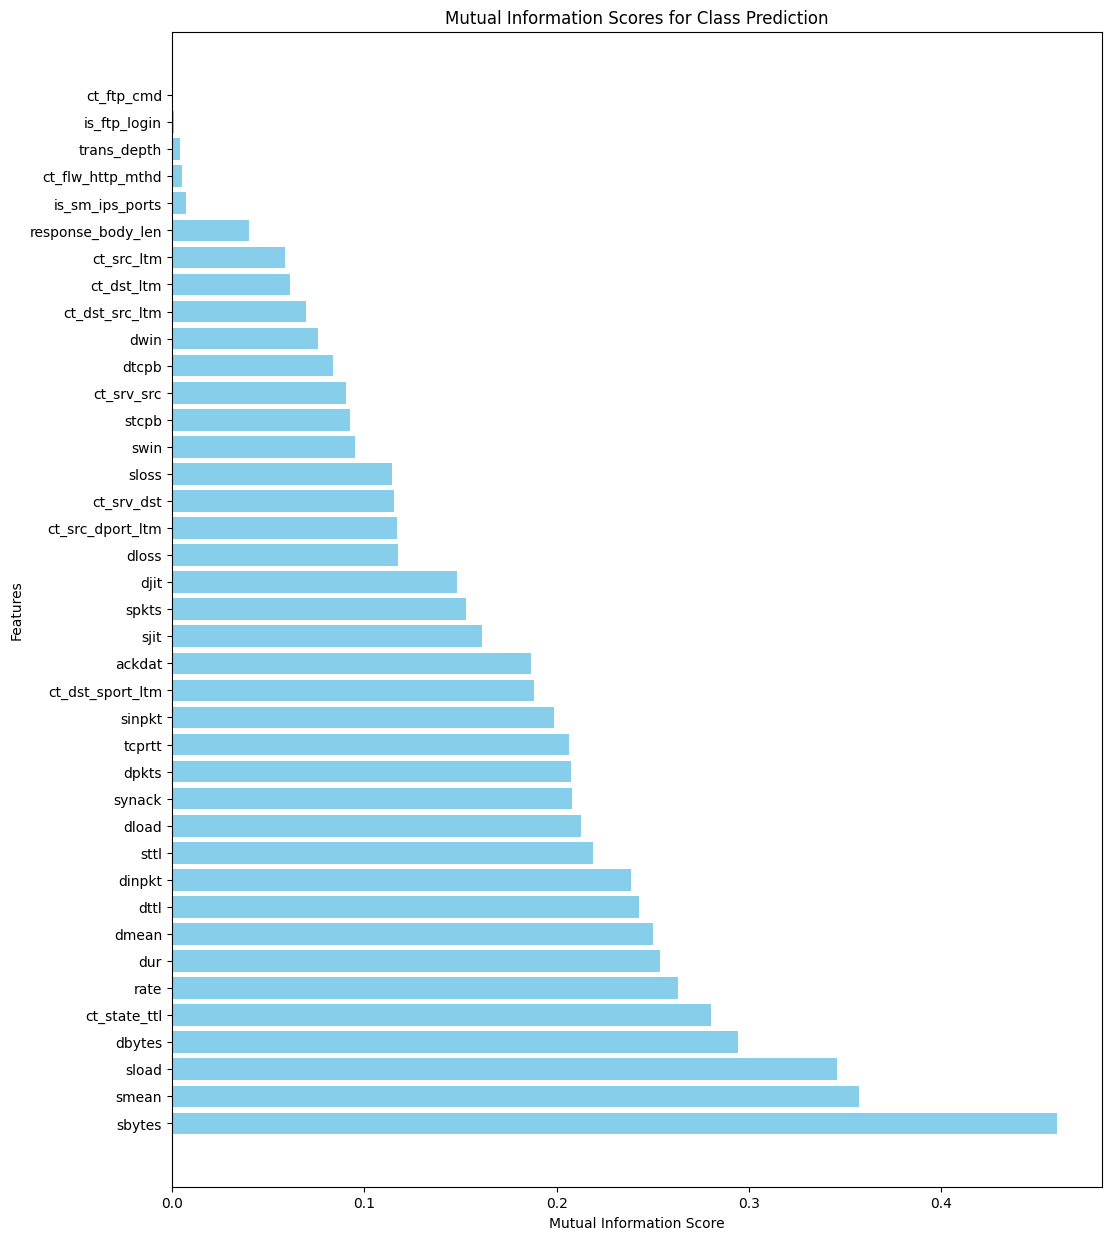

In [12]:
from sklearn.feature_selection import mutual_info_classif

X = train.select_dtypes(include=['int64', 'float64']).drop('label', axis=1)

y = train['label']

mutual_info = mutual_info_classif(X, y, random_state=42)

mi_scores = pd.Series(mutual_info, index=X.columns, name='Mutual Information Score')
mi_scores = mi_scores.sort_values(ascending=False)
plt.figure(figsize=(12, 15))
plt.barh(mi_scores.index, mi_scores, color='skyblue')
plt.title('Mutual Information Scores for Class Prediction')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

In [13]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [15]:
X = df.drop('attack_cat', axis=1)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [16]:
print(y_train.value_counts())

attack_cat
Normal            74400
Generic           47097
Exploits          35620
Fuzzers           19397
DoS               13082
Reconnaissance    11189
Analysis           2142
Backdoor           1863
Shellcode          1209
Worms               139
Name: count, dtype: int64


In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

In [18]:
# Define the sampling strategies
sampling_strategy_over = {
    "Generic": 50000,
    "Exploits": 45000,
    "Fuzzers": 25000,
    "DoS": 15000,
    "Reconnaissance": 12000,
    "Analysis": 3000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 500
}

sampling_strategy_under = {
    "Normal": 70000
}

over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [19]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for Conv1D if necessary
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.values.reshape(-1, 1))


In [20]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())

attack_cat
Normal            70000
Generic           50000
Exploits          45000
Fuzzers           25000
DoS               15000
Reconnaissance    12000
Analysis           3000
Backdoor           2000
Shellcode          2000
Worms               500
Name: count, dtype: int64


In [19]:
# class weights to focus more on minority classes
from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)

class_name_to_index = {class_name: index for index, class_name in enumerate(np.unique(y_train_res))}

class_weight_dict = {class_name_to_index[class_name]: weight for class_name, weight in zip(np.unique(y_train_res), class_weights)}


In [22]:
import tensorflow as tf

# Specify the GPU to use
gpu_device = '/device:GPU:1'

In [21]:
!nvidia-smi

Fri Mar 29 21:43:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:01:00.0 Off |                    0 |
| N/A   43C    P0             65W /  300W |   81022MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [23]:
with tf.device(gpu_device):

    cnn_without_finetuning = Sequential()

    # First Convolutional Layer
    cnn_without_finetuning.add(Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(X_train_scaled.shape[1], 1)))
    cnn_without_finetuning.add(Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
    cnn_without_finetuning.add(MaxPooling1D(pool_size=2, strides=2))
    cnn_without_finetuning.add(Dropout(0.002))
    cnn_without_finetuning.add(BatchNormalization())

    # Second Convolutional Layer
    cnn_without_finetuning.add(Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
    cnn_without_finetuning.add(Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
    cnn_without_finetuning.add(MaxPooling1D(pool_size=2, strides=2))
    cnn_without_finetuning.add(Dropout(0.002))
    cnn_without_finetuning.add(BatchNormalization())

    # Flatten and Dense Layers
    cnn_without_finetuning.add(Flatten())
    cnn_without_finetuning.add(Dense(32, activation='relu'))
    cnn_without_finetuning.add(Dense(y_train_one_hot.shape[1], activation='softmax'))  # Number of neurons equals the number of classes

    # Compile the model
    cnn_without_finetuning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model
    history = cnn_without_finetuning.fit(X_train_scaled, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test_one_hot) )

Epoch 1/10


2024-03-29 21:43:32.927704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-29 21:43:33.984326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1734029050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-29 21:43:33.984369: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 21:43:33.984383: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 21:43:33.994001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 21:43:34.086573: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6442/6442 [==============================] - 57s 8ms/step - loss: 0.4120 - accuracy: 0.8516 - val_loss: 0.4207 - val_accuracy: 0.8456
Epoch 2/10
6442/6442 [==============================] - 53s 8ms/step - loss: 0.3702 - accuracy: 0.8620 - val_loss: 0.3789 - val_accuracy: 0.8658
Epoch 3/10
6442/6442 [==============================] - 53s 8ms/step - loss: 0.3554 - accuracy: 0.8656 - val_loss: 0.3485 - val_accuracy: 0.8689
Epoch 4/10
6442/6442 [==============================] - 53s 8ms/step - loss: 0.3485 - accuracy: 0.8675 - val_loss: 0.3428 - val_accuracy: 0.8694
Epoch 5/10
6442/6442 [==============================] - 54s 8ms/step - loss: 0.3416 - accuracy: 0.8692 - val_loss: 0.3350 - val_accuracy: 0.8714
Epoch 6/10
6442/6442 [==============================] - 55s 9ms/step - loss: 0.3366 - accuracy: 0.8709 - val_loss: 0.3452 - val_accuracy: 0.8699
Epoch 7/10
6442/6442 [==============================] - 55s 8ms/step - loss: 0.3328 - accuracy: 0.8717 - val_loss: 0.3307 - val_accuracy: 0.8

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_without_finetuning.evaluate(X_test_scaled, y_test_one_hot)

print("Test Accuracy: {: .2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

   1/1611 [..............................] - ETA: 7:00 - loss: 0.4277 - accuracy: 0.8750

2024-03-29 22:02:43.455003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-29 22:02:43.504609: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.77MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-29 22:02:43.504661: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.77MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-29 22:02:43.571987: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains 

1611/1611 [==============================] - 6s 4ms/step - loss: 0.3207 - accuracy: 0.8759
Test Accuracy:  87.59%
Test Loss: 32.07%


2024-03-29 22:02:49.542174: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 258.24MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-29 22:02:49.542260: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 258.24MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-29 22:02:49.559162: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 774.62MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-29 22:02:49.559230: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

In [25]:
y_true = np.argmax(y_test_one_hot, axis=1)


In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the classes with the model
y_pred = cnn_without_finetuning.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Get unique class names from y_test
class_names = np.unique(y_test)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

1611/1611 [==============================] - 5s 3ms/step
                precision    recall  f1-score   support

      Analysis       0.75      0.15      0.25       538
      Backdoor       0.66      0.04      0.08       471
           DoS       0.52      0.04      0.08      3293
      Exploits       0.61      0.95      0.74      8853
       Fuzzers       0.87      0.87      0.87      4742
       Generic       1.00      0.98      0.99     11849
        Normal       1.00      1.00      1.00     18675
Reconnaissance       0.94      0.71      0.81      2770
     Shellcode       0.63      0.53      0.57       318
         Worms       0.50      0.23      0.32        26

      accuracy                           0.88     51535
     macro avg       0.75      0.55      0.57     51535
  weighted avg       0.88      0.88      0.85     51535



In [27]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = cnn_without_finetuning.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

class_names = np.unique(y_true).astype(str)  

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)


1611/1611 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

           0       0.75      0.15      0.25       538
           1       0.66      0.04      0.08       471
           2       0.52      0.04      0.08      3293
           3       0.61      0.95      0.74      8853
           4       0.87      0.87      0.87      4742
           5       1.00      0.98      0.99     11849
           6       1.00      1.00      1.00     18675
           7       0.94      0.71      0.81      2770
           8       0.63      0.53      0.57       318
           9       0.50      0.23      0.32        26

    accuracy                           0.88     51535
   macro avg       0.75      0.55      0.57     51535
weighted avg       0.88      0.88      0.85     51535



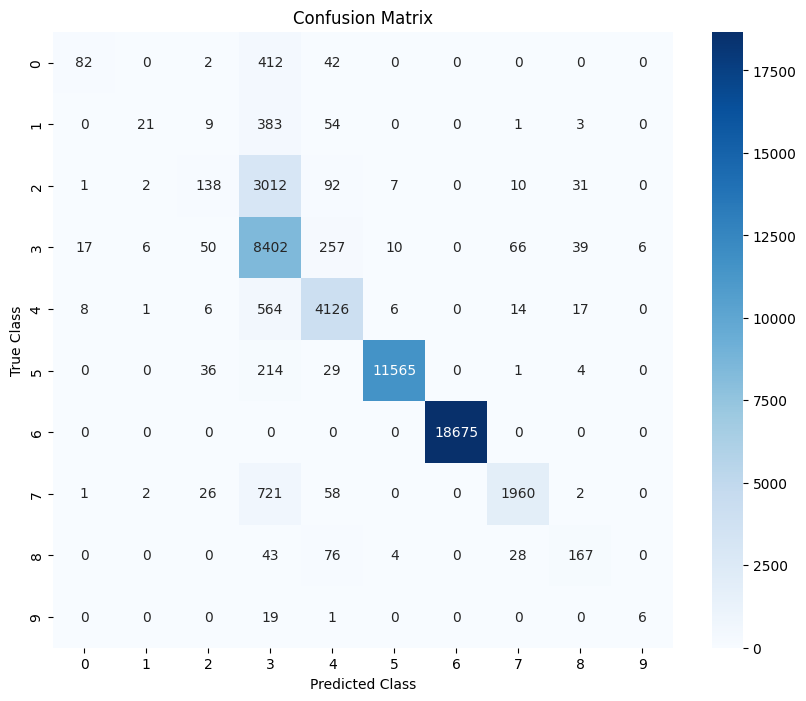

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

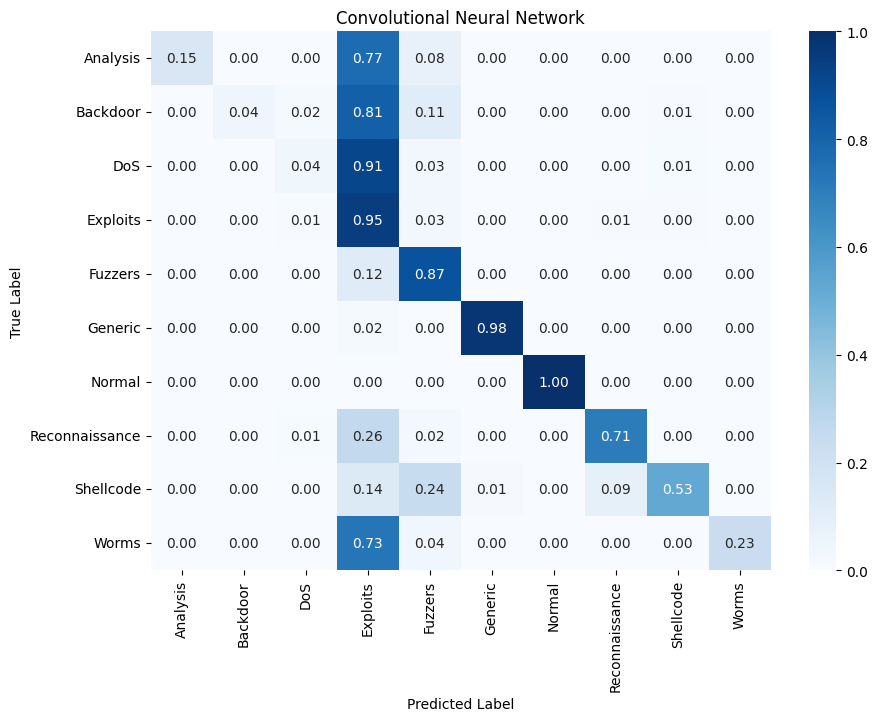

In [29]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix.sum(axis=1)
conf_matrix_normalized = conf_matrix / row_sums[:, np.newaxis]

# Plot the normalized confusion matrixa
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Convolutional Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Micro Average Precision: 0.7482
Micro Average Recall: 0.5498
Micro Average F1-Score: 0.5714
Precision: 0.8784564616734584
Recall: 0.8759483845929951
F1 Score: 0.8524803016648531
Accuracy: 0.8759483845929951


In [37]:
# CNN with fine tune

In [35]:
with tf.device(gpu_device):

    cnn_with_finetuning = Sequential()

    # First Convolutional Layer
    cnn_with_finetuning.add(Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(X_train_scaled.shape[1], 1)))
    cnn_with_finetuning.add(BatchNormalization())
    cnn_with_finetuning.add(Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
    cnn_with_finetuning.add(MaxPooling1D(pool_size=2, strides=2))
    cnn_with_finetuning.add(Dropout(0.002))

    # Second Convolutional Layer
    cnn_with_finetuning.add(Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
    cnn_with_finetuning.add(BatchNormalization())
    cnn_with_finetuning.add(Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'))
    cnn_with_finetuning.add(MaxPooling1D(pool_size=2, strides=2))
    cnn_with_finetuning.add(Dropout(0.002))

    # Flatten and Dense Layers
    cnn_with_finetuning.add(Flatten())
    cnn_with_finetuning.add(Dense(32, activation='relu'))
    cnn_with_finetuning.add(Dense(y_train_one_hot.shape[1], activation='softmax'))  # Number of neurons equals the number of classes

    # Early Stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,  
        patience=2, 
        min_lr=1e-6
    )

    # Compile the model
    cnn_with_finetuning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    # Fit the model
    history = cnn_with_finetuning.fit(X_train_scaled, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test_one_hot),callbacks=[early_stopping, reduce_lr])

Epoch 1/10
6442/6442 [==============================] - 57s 9ms/step - loss: 0.4159 - accuracy: 0.8505 - val_loss: 0.3934 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 2/10
6442/6442 [==============================] - 56s 9ms/step - loss: 0.3661 - accuracy: 0.8623 - val_loss: 0.3529 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 3/10
6442/6442 [==============================] - 55s 9ms/step - loss: 0.3531 - accuracy: 0.8657 - val_loss: 0.3411 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 4/10
6442/6442 [==============================] - 55s 9ms/step - loss: 0.3438 - accuracy: 0.8687 - val_loss: 0.3341 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 5/10
6442/6442 [==============================] - 55s 9ms/step - loss: 0.3381 - accuracy: 0.8706 - val_loss: 0.3320 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 6/10
6442/6442 [==============================] - 55s 9ms/step - loss: 0.3346 - accuracy: 0.8708 - val_loss: 0.3341 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 7/10
6442/6442 [==============================

In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_with_finetuning.evaluate(X_test_scaled, y_test_one_hot)

print("Test Accuracy: {: .2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

1611/1611 [==============================] - 6s 4ms/step - loss: 0.3143 - accuracy: 0.8776
Test Accuracy:  87.76%
Test Loss: 31.43%


In [37]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = cnn_with_finetuning.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = np.unique(y_test)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

1611/1611 [==============================] - 5s 3ms/step
                precision    recall  f1-score   support

      Analysis       0.75      0.19      0.30       538
      Backdoor       0.67      0.01      0.03       471
           DoS       0.60      0.04      0.07      3293
      Exploits       0.62      0.93      0.74      8853
       Fuzzers       0.86      0.88      0.87      4742
       Generic       1.00      0.98      0.99     11849
        Normal       1.00      1.00      1.00     18675
Reconnaissance       0.90      0.76      0.82      2770
     Shellcode       0.65      0.58      0.61       318
         Worms       0.50      0.19      0.28        26

      accuracy                           0.88     51535
     macro avg       0.75      0.56      0.57     51535
  weighted avg       0.88      0.88      0.85     51535



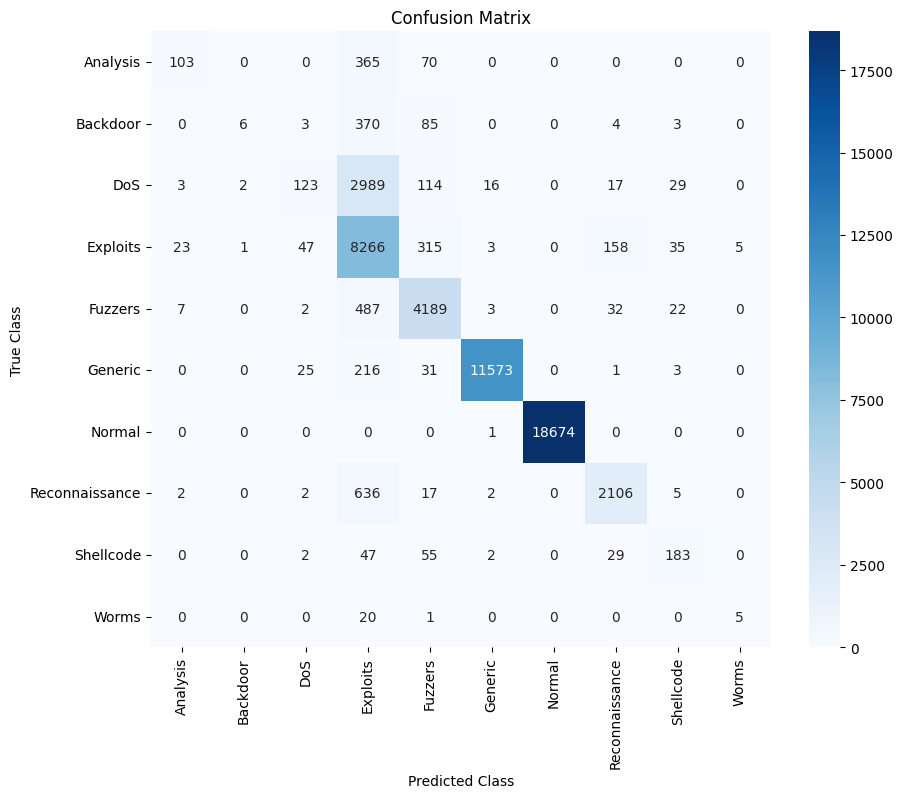

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

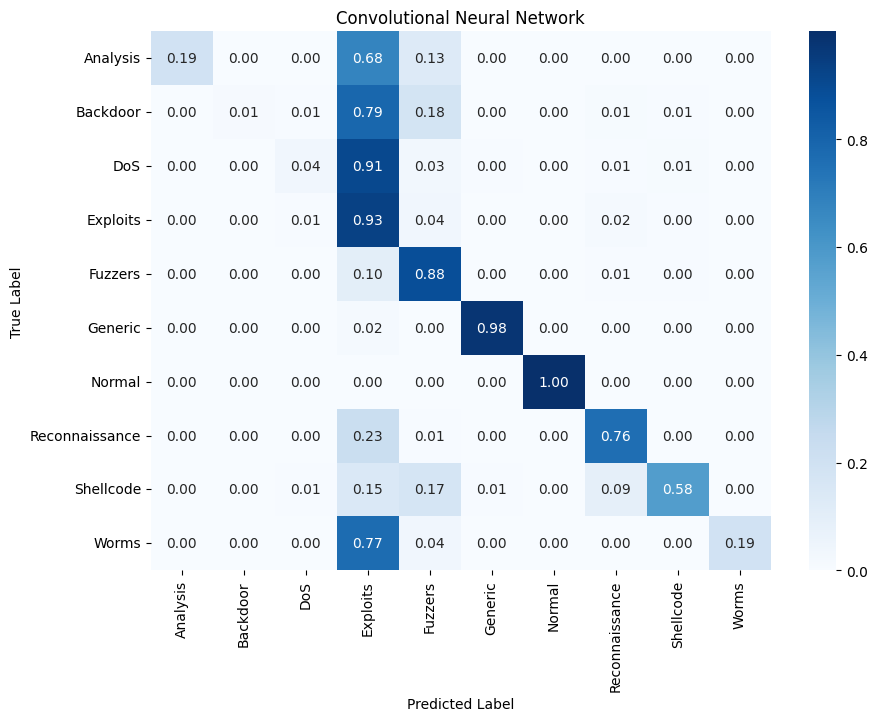

In [39]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix.sum(axis=1)
conf_matrix_normalized = conf_matrix / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Convolutional Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Micro Average Precision: 0.7541
Micro Average Recall: 0.5563
Micro Average F1-Score: 0.5714
Precision: 0.8817239481821634
Recall: 0.8776171533908994
F1 Score: 0.8531694936415328
Accuracy: 0.8776171533908994
